In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy

In [2]:
np.set_printoptions(threshold=np.inf)

## References

https://cse.lab.imtlucca.it/~bemporad/publications/papers/ijc_rtiltv.pdf

https://web.stanford.edu/~boyd/papers/pdf/fast_mpc.pdf

https://www.imtek.de/professuren/systemtheorie/events/dateien/directshootingmethods

https://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/cartPoleCollocation.svg#frame1114

In [3]:
def rk4(x_init, t_init, dt, f):
    # f = f(t, x) - the function representing the time derivative of the state vector, x
    # returns the next state
    k1 = f(t_init, x_init)
    k2 = f(t_init + dt/2, x_init + dt * k1/2)
    k3 = f(t_init + dt/2, x_init + dt * k2/2)
    k4 = f(t_init + dt, x_init + dt * k3)

    return x_init + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

In [4]:
def affine_linear_dynamics(t, x, A, p):
    # t = time
    # x = state, shape [n]
    # A = linearized dynamics, shape [n, n]
    # p = affine term, shape [n]
    return np.dot(A, x) + p

In [5]:
def cartpole_dynamics(t, z, u, u_max=1.0, m_cart=1.0, m_pend=1.0, l_pend=1.0):
    # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    # u = force exerted on cart, clamped between +/-u_max
    u = np.clip(u, -u_max, u_max)
    cosz1 = np.cos(z[1])
    sinz1 = np.sin(z[1])
    alpha = (m_pend + m_cart) / (m_pend * l_pend)
    g = 9.8
    denom = (cosz1 * cosz1 - alpha)

    return np.array(
        [
            z[2],
            z[3],
            (-g * sinz1 * cosz1 - u - (z[3]**2) * sinz1) / denom,
            (alpha * g * sinz1 + u * cosz1 + (z[3]**2 * sinz1 * cosz1)) / denom
         ]
    )

In [6]:
def pendulum_position(z, l_pend):
    # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])

In [99]:
def cartpole_demo(z_init, u_init, t_max, u_max=1.0):
    # z_init = [1.0, 2.0 * np.pi / 3.0, 0.0, 1.0]
    zs = []
    zs.append(copy.copy(z_init))
    dt = 0.01
    # unforced_dynamics = lambda t, y : cartpole_dynamics(t, y, 0.0)
    const_force_dynamics = lambda t, y : cartpole_dynamics(t, y, u_init, u_max)
    
    for i in range(int(t_max / dt)):
        zs.append(rk4(zs[-1], dt * i, dt, const_force_dynamics))

    pendulum_positions = [pendulum_position(z, 1.0) for z in zs]

    # fig = plt.figure()
    # ax = fig.add_subplot()
    # plt.plot([p[0] for p in pendulum_positions], [p[1] for p in pendulum_positions])
    # # ax.set_aspect('equal', adjustable='box')
    # ax.axis('equal')
    # plt.show()
    plot_pendulum_time_sequence(zs, 1.0)

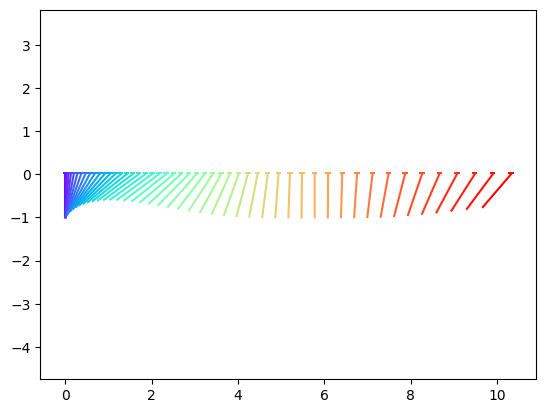

In [147]:
cartpole_demo([0.0, 0.0, 0.0, 0.0], 10.0, 2, u_max=10.0)

In [115]:
def linearized_cartpole_dynamics(t, z, u, u_max=1.0, m_cart=1.0, m_pend=1.0, l_pend=1.0):
    # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    # u = force exerted on cart, clamped between +/-u_max
    # linearizes the cartpole dynamics about `z` and `u`, returns the `A` and `b` matrices
    #    `z_dot = f(t, z, u) ~ f(t_0, z_0, u_0) + grad(f, z)(t_0, z_0, u_0) ^ T (z - z_0) + grad(f, u)(t_0, z_0, u_0) ^ T (u - u_0)
    #    `A` - Jacobian of cartpole dynamics with respect to state, `z`
    #    `r` - affine part of the linear approximation of cartpole dynamics
    #    `b` - Jacobian of cartpole dynamics with respect to control input, `u`
    # Returns `A`, `b`, `r`
    A = np.zeros((4, 4))
    b = np.zeros(4)

    cosz1 = np.cos(z[1])
    sinz1 = np.sin(z[1])
    alpha = (m_pend + m_cart) / (m_pend * l_pend)
    g = 9.8
    denom = (cosz1 * cosz1 - alpha)

    A[0, 2] = 1.0
    A[1, 3] = 1.0
    A[2, 1] = ((g * sinz1 * sinz1 - g * cosz1 * cosz1 - (z[3] ** 2) * cosz1) / denom) + 2.0 * (((-g * sinz1 * cosz1 - u - (z[3] ** 2) * sinz1) * sinz1 * cosz1)) / (denom * denom)
    A[2, 3] = -2.0 * z[3] * sinz1 / denom
    A[3, 1] = ((alpha * g * cosz1 - u * sinz1 - (z[3] ** 2) * (sinz1 * sinz1 - cosz1 * cosz1)) / denom) + 2.0 * (alpha * g * sinz1 + u * cosz1 + (z[3] ** 2) * sinz1 * cosz1) * (sinz1 * cosz1) / (denom * denom)
    A[3, 3] = 2.0 * z[3] * sinz1 * cosz1 / denom

    b[2] = -1.0 / denom
    b[3] = cosz1 / denom

    r = cartpole_dynamics(t, z, u, u_max, m_cart, m_pend, l_pend) - np.dot(A, z) - b * u

    return A, b, r

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + e^{At}\int_{t_0}^{t}e^{A\tau} \left( b u(\tau) + f \right) d\tau
\end{equation}

When $u(\tau) = u_0$ for $t_0 \leq t \leq t$ the convolution integral becomes

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + \left( e^{A(t - t_0)} - \mathbb{I} \right)A^{-1}(b u_0 + f)
\end{equation}

$A \in \mathbb{R}^{n \times n}$ is the Jacobian of the nonlinear system dynamics with respect to $x \in \mathbb{R}^n$

$b \in \mathbb{R}^n$ is the Jacobian of the nonlinear system dynamics with respect to $u \in \mathbb{R}$

$f \in \mathbb{R}^n$ is the constant term that comes from linearizing the system dynamics about a non-fixed point

The state transition matrix is defined as

\begin{equation}
\Phi(t) = e^{At}
\end{equation}

In [116]:
def phi_and_phi_integ(A, delta_t):
    # Returns the state transition matrix and integral of the state transition matrix
    # for an LTI system. This is meant to be used to calculate the discrete state transition
    # equations for systems with constant input over the interval `dt`.
    
    def mat_exp_ish(A, dt):
        prev_mult = np.eye(np.shape(A)[0], np.shape(A)[1])
        sum = prev_mult
        for n in range(int(np.log(1e-15)/np.log(dt))):
            mult = np.dot(prev_mult, A) * dt / (n + 1)
            sum += mult
            prev_mult = mult
        return sum

    def mat_exp_ish_integral(A, dt):
        prev_mult = np.eye(np.shape(A)[0], np.shape(A)[1]) * dt
        sum = prev_mult
        for n in range(int(np.log(1e-15)/np.log(dt))):
            mult = np.dot(prev_mult, A) * dt / (n + 2)
            sum += mult
            prev_mult = mult
        return sum

    return mat_exp_ish(A, delta_t), mat_exp_ish_integral(A, delta_t)

In [117]:
def plot_time_sequence(positions):
    '''
    Plots a sequence of 2d positions in the xy plane, where x and y indicate the position of
    *something* that has evolved over time.
    '''
    colors = cm.rainbow(np.linspace(0, 1, len(positions)))
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.scatter([p[0] for p in positions], [p[1] for p in positions], color=colors)
    ax.axis('equal')
    plt.show()

In [156]:
def plot_pendulum_time_sequence(states, l_pend, keyframe_stride=4):
    '''
    Plots the cart position, pendulum arm, and pendulum mass position for a sequence of 4d
    states indicating the system's [cart_pos, pendulum_angle, cart_speed, pendulum_angular_speed].

    Add shapes to matplotlib plot:
    https://www.scaler.com/topics/matplotlib/plot-shape-matplotlib/
    '''
    #     import matplotlib.pyplot as plt
    # plt.axes()
    # # Radius: 1, face-color: red, edge-color: blue
    # circle = plt.Circle((1,1),0.5, fc='red',ec="blue")
    # plt.gca().add_patch(circle)
    # plt.axis('scaled')
    # plt.show()

    positions = [pendulum_position(z, l_pend) for z in states]
    
    # return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])
    keyframe_states = [s for i, s in enumerate(states) if (i % keyframe_stride) == 0]
    keyframe_colors = cm.rainbow(np.linspace(0, 1, int(len(states) / keyframe_stride) + 1))
    colors = cm.rainbow(np.linspace(0, 1, len(states)))
    fig = plt.figure()
    ax = fig.add_subplot()
    for i, ks in enumerate(keyframe_states):
        cart = plt.Rectangle((ks[0] - 0.125/2, 0.0), 0.125, 0.125/2, fc=keyframe_colors[i])
        plt.plot([ks[0], ks[0] + l_pend * np.sin(ks[1])], [0.0, -l_pend * np.cos(ks[1])], color=keyframe_colors[i])
        plt.gca().add_patch(cart)
    plt.scatter([p[0] for p in positions], [p[1] for p in positions], color=colors, s=0.25)
    plt.axis('equal')
    plt.show()

In [166]:
def lti_sim_with_input(F, b, f, u_func, z_init, dt, t_0, t_f, state_plotter_func):
    '''
    Generates a dense set of states given some linearized dynamics, control input, and initial
    state.
    '''
    zs = [copy.deepcopy(z_init)]

    t = t_0
    phi, phi_integ = phi_and_phi_integ(F, dt)

    while t < t_f:
        u_now = u_func(t)
        zs.append(np.dot(phi, zs[-1]) + np.dot(phi_integ, b * u_now + f))
        t += dt

    if state_plotter_func is not None:
        system_positions = [state_plotter_func(z) for z in zs]
        plot_time_sequence(system_positions)
        t_vals = [dt * n for n in range(int((t_f - t_0) / dt))]
        plt.plot(t_vals, [u_func(t) for t in t_vals])
    
    print("final state:", zs[-1])

    return zs

In [158]:
def build_A_and_c_mat_exp(F, b, f, z_init, z_final, N, dt):
    # Builds the parameters of the linear equation Ax = c from the
    # parameters of an LTI dynamical system using a Taylor series
    # expansion of the matrix exponential solution to the dynamic equation
    # z_dot = F * z + b * u + f. `A` and `c` represent
    # collocation constraints on the dynamics of a system.
    # This is for LTI dynamical systems where z_dot = Fz + bu + f
    #    F is a matrix
    #    b is a vector
    #    z is a vector
    #    u is a scalar
    # F - F matrix of z_dot = Fz + bu + f
    # b - b vector of z_dot = Fz + bu + f
    # f - f vector of z_dot = Fz + bu + f
    # N - the number of time points
    # dt - delta time between time points

    phi, phi_integ = phi_and_phi_integ(F, dt)
    
    state_vec_size = np.shape(F)[0]
    # `state_vec_size * 2` extra rows are tacked on to `A` and `c`
    # to handle the boundary constraints on `z_0` and `z_N`
    A = np.zeros((state_vec_size * (N + 2), (state_vec_size + 1) * (N + 1)))
    c = np.zeros(state_vec_size * (N + 2))

    # The index in the vector of decision variables where the first element of the
    # state vector from the dynamical system at the first time step appears
    control_input_offset = N + 1
    for i in range(N):
        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i
        ] = -np.dot(phi_integ, b)

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + i * state_vec_size : control_input_offset + i * state_vec_size + state_vec_size
        ] = -phi

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + (i + 1) * state_vec_size : control_input_offset + (i + 1) * state_vec_size + state_vec_size
        ] = np.eye(state_vec_size)

        c[i * state_vec_size : i * state_vec_size + state_vec_size] = np.dot(phi_integ, f)

    A[
        N * state_vec_size: N * state_vec_size + state_vec_size,
        control_input_offset + 0: control_input_offset + 0 + state_vec_size
    ] = np.eye(state_vec_size)

    c[N * state_vec_size: N * state_vec_size + state_vec_size] = z_init

    A[
        (N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size,
        control_input_offset + N * state_vec_size: control_input_offset + N * state_vec_size + state_vec_size
    ] = np.eye(state_vec_size)

    c[(N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size] = z_final

    return A, c

In [159]:
def build_kkt_matrix(H, A):
    # H - Hessian of the quadratic objective function with respect to the
    #     decision variables. (This is probably a square matrix that only
    #     touches the `u` decision variables).
    # A - Equality constraint matrix

    K = np.zeros(
        (np.shape(H)[0] + np.shape(A)[0], np.shape(H)[1] + np.shape(A)[0])
    )

    K[
        0: np.shape(H)[0],
        0: np.shape(H)[1]
    ] = H
    K[
        np.shape(H)[0]: np.shape(H)[0] + np.shape(A)[0],
        0: np.shape(A)[1]
    ] = A
    K[
        0: np.shape(A)[1],
        np.shape(H)[0]: np.shape(H)[0] + np.shape(A)[0]
    ] = np.transpose(A)

    return K

In [160]:
def calculate_obj_grad_hess(Q, x, t, u_min, u_max, N, grad_hess = True):
    # Q - quadratic cost matrix (should be square with one dimension
    #     equal to the shape of `x`
    # x - decision variable made up of control inputs (at the top) and 
    #     dynamical states (at the bottom)
    # t - value for interior point method

    u_vals = x[0:(N + 1)]
    
    obj = 0.5 * np.dot(np.dot(Q, x), x) - (1.0/t) * np.sum(np.log(u_max - u_vals)) - (1.0/t) * np.sum(np.log(u_vals - u_min))

    if not grad_hess:
        return obj, None, None

    grad = np.zeros_like(x)

    grad[0:(N + 1)] = np.dot(Q, x)[0: (N + 1)] + (1.0/t) * ((-1.0 / (u_vals - u_min)) + (1.0 / (u_max - u_vals)))

    hess = np.zeros((np.shape(x)[0], np.shape(x)[0]))
    hess[0:(N + 1), 0:(N + 1)] = Q[0:(N + 1), 0:(N + 1)] + (1.0/t) * np.diag((1.0 / ((u_vals - u_min) * (u_vals - u_min))) + (1.0 / ((u_max - u_vals) * (u_max - u_vals))))

    return obj, grad, hess

In [161]:
def calc_residual(x, v, A, c, Q, t, u_min, u_max, N):
    obj, grad, _ = calculate_obj_grad_hess(Q, x, t, u_min, u_max, N)

    return np.hstack(
        [
            grad + np.dot(np.transpose(A), v),
            np.dot(A, x) - c
        ]
    )

def infeasible_newton(x_init, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100, eps=1e-8, alpha=0.5, beta=0.9):
    # x_init = initial decision variable, x = [u0, u1, ..., uN, z0, z1, ..., zN]
    # v_init = initial equality constraint langrange multiplier, v.shape = [(N + 2) * state_vec_size] (where state_vec_size is the
    #          dimension of a single state variable for the system dynamics
    # barrier_t = initial interior point barrier method factor
    # Q      = quadratic cost coefficients, Q.shape = [(state_vec_size + 1) * (N + 1), (state_vec_size + 1) * (N + 1)]
    # A      = Equality constraint matrix, `Ax = c` 
    # c      = Equality constraint vector, `Ax = c`
    # u_min  = scalar minimum input value
    # u_max  = scalar maximum input value
    # N      = The number of non-zero time points in the trajectory optimization
    #          [t_0, t_1, t_2, ..., t_{N-2}, t_{N-1}, T_{N}], where t_0 = 0.0

    assert(len(np.shape(x_init)) == 1)
    assert(len(np.shape(u_min)) == 0)
    assert(len(np.shape(u_max)) == 0)
    assert(np.shape(Q) == (np.shape(x_init)[0], np.shape(x_init)[0]))
    assert(N > 0)

    x = copy.deepcopy(x_init)
    v = copy.deepcopy(v_init)

    residual = calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)

    num_iters = 0
    
    while np.linalg.norm(residual) >= eps and (num_iters < max_iters):
        # calculate delta_x, delta_v from the primal+dual Newton step
        obj, grad, hess = calculate_obj_grad_hess(Q, x, barrier_t, u_min, u_max, N)

        residual = calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)
        K = build_kkt_matrix(hess, A)

        # print("residual: ", np.linalg.norm(residual))

        delta_x_v = np.linalg.solve(K, -residual)

        delta_x = delta_x_v[0:x_init.shape[0]]
        delta_v = delta_x_v[x_init.shape[0]:]

        # backtracking line search on the l2 norm of the residual and inequality
        # constrained decision variables to get step size
        s = 1.0
        while np.any((x + s * delta_x)[0:(N + 1)] < u_min) or np.any((x + s * delta_x)[0:(N + 1)] > u_max) or np.linalg.norm(calc_residual(x + s * delta_x, v + s * delta_v, A, c, Q, barrier_t, u_min, u_max, N)) > (1.0 - alpha * s) * np.linalg.norm(residual):
            s = s * beta

        # print("step size: ", s)
        
        x = x + s * delta_x
        v = v + s * delta_v

        # print("step: ", s)
        # print("obj: ", obj)
        
        num_iters += 1

    print("num iters: ", num_iters)
    print("residual: ", np.linalg.norm(calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)))
    # print("constraint satisfaction: ", np.linalg.norm(np.dot(A, x) - c))
    # print("constraint satisfaction: ", np.dot(A, x) - c)

    return x


In [162]:
def feasible_newton(x_init, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100, eps=1e-8, alpha=0.5, beta=0.9):
    # x_init = initial decision variable, x = [u0, u1, ..., uN, z0, z1, ..., zN]
    # v_init = initial equality constraint langrange multiplier, v.shape = [(N + 2) * state_vec_size] (where state_vec_size is the
    #          dimension of a single state variable for the system dynamics
    # barrier_t = initial interior point barrier method factor
    # Q      = quadratic cost coefficients, Q.shape = [(state_vec_size + 1) * (N + 1), (state_vec_size + 1) * (N + 1)]
    # A      = Equality constraint matrix, `Ax = c` 
    # c      = Equality constraint vector, `Ax = c`
    # u_min  = scalar minimum input value
    # u_max  = scalar maximum input value
    # N      = The number of non-zero time points in the trajectory optimization
    #          [t_0, t_1, t_2, ..., t_{N-2}, t_{N-1}, T_{N}], where t_0 = 0.0

    assert(len(np.shape(x_init)) == 1)
    assert(len(np.shape(u_min)) == 0)
    assert(len(np.shape(u_max)) == 0)
    assert(np.shape(Q) == (np.shape(x_init)[0], np.shape(x_init)[0]))
    assert(N > 0)

    x = copy.deepcopy(x_init)
    v = copy.deepcopy(v_init)

    obj, grad, hess = calculate_obj_grad_hess(Q, x, barrier_t, u_min, u_max, N)
    K = build_kkt_matrix(hess, A)
    delta_x_v = np.linalg.solve(K, np.hstack([-grad, np.zeros(np.shape(A)[0])]))

    delta_x = delta_x_v[0:x_init.shape[0]]
    
    num_iters = 0
    
    while np.linalg.norm(np.dot(np.dot(delta_x, hess), delta_x)) >= eps and (num_iters < max_iters):
        # calculate delta_x, delta_v from the primal+dual Newton step
        obj, grad, hess = calculate_obj_grad_hess(Q, x, barrier_t, u_min, u_max, N)

        K = build_kkt_matrix(hess, A)

        delta_x_v = np.linalg.solve(K, np.hstack([-grad, np.zeros(np.shape(A)[0])]))

        delta_x = delta_x_v[0:x_init.shape[0]]
        delta_v = delta_x_v[x_init.shape[0]:]

        # backtracking line search on the l2 norm of the residual and inequality
        # constrained decision variables to get step size
        s = 1.0
        while np.any((x + s * delta_x)[0:(N + 1)] < u_min) or np.any((x + s * delta_x)[0:(N + 1)] > u_max) or calculate_obj_grad_hess(Q, x + s * delta_x, barrier_t, u_min, u_max, N, False)[0] > obj + alpha * s * np.dot(grad, delta_x):
            s = s * beta

        #print("step size: ", s)
        
        x = x + s * delta_x
        v = v + s * delta_v

        # print("step: ", s)
        # print("obj: ", obj)
        
        num_iters += 1

    print("num iters: ", num_iters)
    # print("constraint satisfaction: ", np.linalg.norm(np.dot(A, x) - c))
    # print("constraint satisfaction: ", np.dot(A, x) - c)

    return x


In [170]:
state_vec_size = 4
# Number of timesteps
N = 64
# Total amount of time
T = 4
# delta time between steps
dt = T / N

Q = np.zeros(((N + 1) * (state_vec_size + 1), (N + 1) * (state_vec_size + 1)))
Q[0:(N + 1), 0:(N + 1)] = np.eye(N + 1)
u_min = -20.0
u_max = 20.0

# Initial state, used for linearizing dynamics
# z_0 = np.array([0.0, 2 * np.pi / 3.0, 0.0, 0.0])
z_0 = np.array([0.0, 0.0, 0.0, 0.0])
u_0 = (u_max + u_min) / 2.0
t_0 = 0.0
m_pend = 0.3
l_pend = 0.5

F, b, f = linearized_cartpole_dynamics(t_0, z_0, u_0, u_max, m_cart=m_pend, m_pend=m_pend, l_pend=l_pend)

z_final = np.array([2.0, np.pi, 0.0, 0.0])

A, c = build_A_and_c_mat_exp(F, b, f, z_0, z_final, N, dt)

# zs for warm-starting infeasible newton
delta_tau = (1.0 / N)
warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_final for i in range(N + 1)]
warm_us = [0.000,] * (N + 1)

print("z_0: ", warm_zs[0])
print("z_f: ", warm_zs[-1])

x_init = np.hstack(warm_us + warm_zs)

v_init = np.ones(state_vec_size * (N + 2)) * 0.01
barrier_t = 20.0

print("x init shape:", np.shape(x_init))
print("Q shape: ", np.shape(Q))

z_0:  [0. 0. 0. 0.]
z_f:  [2.         3.14159265 0.         0.        ]
x init shape: (325,)
Q shape:  (325, 325)


num iters:  5
residual:  1.8049968774524612e-12
num iters:  4
num iters:  3
num iters:  2
num iters:  0
num iters:  2
num iters:  0
num iters:  0
num iters:  0
num iters:  0
num iters:  0


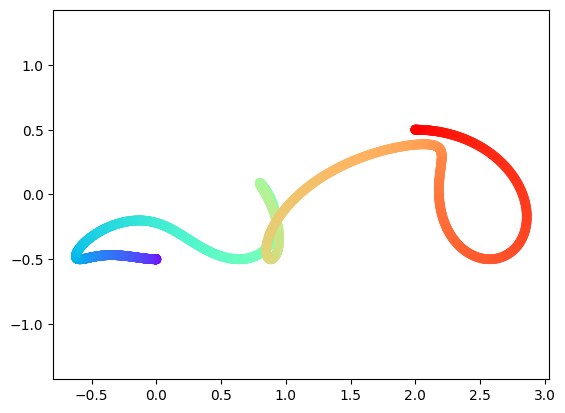

final state: [ 2.00000000e+00  3.14159265e+00  1.09504419e-16 -7.66400832e-15]


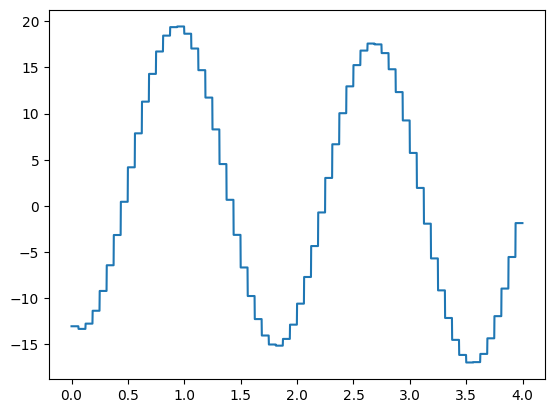

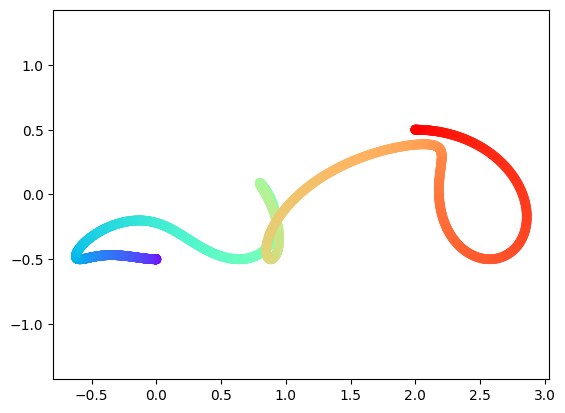

final state: [ 2.00000000e+00  3.14159265e+00  1.09504419e-16 -7.66400832e-15]


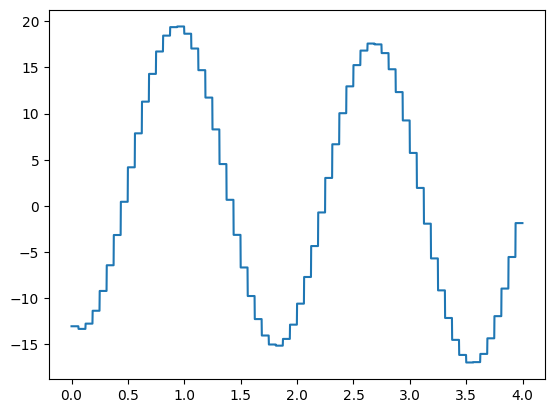

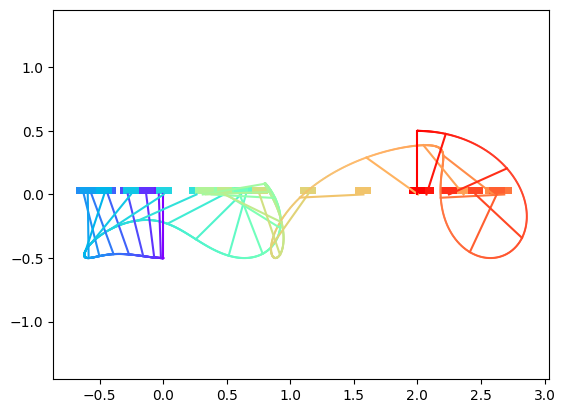

In [171]:
x_out = infeasible_newton(x_init, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100)

barrier_lambda = 10.0
for i in range(10):
    barrier_t *= barrier_lambda
    x_out = feasible_newton(x_out, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100)
x_out2 = x_out

u_func = lambda t: x_out[int(min(t / (T / N), N))]

dt = T / (N * 32)

state_plotter_func = lambda z: pendulum_position(z, l_pend)
lti_sim_with_input(F, b, f, u_func, z_0, dt, t_0, T, state_plotter_func)

u_func = lambda t: x_out2[int(min(t / (T / N), N))]
dense_zs = lti_sim_with_input(F, b, f, u_func, z_0, dt, t_0, T, state_plotter_func)

states = np.reshape(x_out2[N + 1:], ((N + 1), state_vec_size))

# plot_pendulum_time_sequence(states, l_pend, 4)
plot_pendulum_time_sequence(dense_zs, l_pend, 64)

In [165]:
len(x_out2[N + 1:]) / 4

65.0